## Random Sampling To Estimate Pi

![RS](PI.png "Pi")

* Languages:    Python & R
* Requirements: Spark
* Author: Ian Brooks
* Follow: [LinkedIn - Ian Brooks PhD](https://www.linkedin.com/in/ianrbrooksphd/)

### Download Python Libs with PIP

In [1]:
!pip install plotly --upgrade 

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Requirement already up-to-date: plotly in ./.local/lib/python2.7/site-packages (4.9.0)
You should consider upgrading via the '/usr/local/bin/python2.7 -m pip install --upgrade pip' command.


In [2]:
!pip install ipympl

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


You should consider upgrading via the '/usr/local/bin/python2.7 -m pip install --upgrade pip' command.


### List Files

In [22]:
!ls -l

total 404
-rw-r--r-- 1 cdsw cdsw   1616 Jun 25 07:25 analysis.r
-rw-r--r-- 1 cdsw cdsw    153 Jun 25 07:25 config.yml
-rw-r--r-- 1 cdsw cdsw    146 Jun 25 07:25 entry.R
-rw-r--r-- 1 cdsw cdsw  96250 Sep  8 12:59 EstResults.ipynb
-rwx------ 1 cdsw cdsw   3118 Sep  8 13:06 PIEstimateResults.csv
-rwxrwxrwx 1 cdsw cdsw  73068 Sep  1 21:34 pi_experiments.json
-rwx------ 1 cdsw cdsw 154131 Sep  1 18:54 PI.png
-rwx------ 1 cdsw cdsw  11136 Sep  2 17:53 PowersOf10.gif
drwxr-sr-x 2 cdsw cdsw   6144 Sep  1 15:01 R
-rw-r--r-- 1 cdsw cdsw   2655 Sep  1 18:32 RandomSampleEstPi.ipynb
-rwx------ 1 cdsw cdsw   1585 Sep  2 17:54 README.md
-rw-r--r-- 1 cdsw cdsw   6656 Sep  2 13:29 Results.ipynb
-rwx------ 1 cdsw cdsw   1504 Sep  1 19:31 RS_estimatePi.py
-rw-r--r-- 1 cdsw cdsw   2723 Sep  2 15:40 RS_estimatePi.R
-rwx------ 1 cdsw cdsw   1402 Sep  1 21:06 RS_PySpark16Partions.py
-rwx------ 1 cdsw cdsw   1400 Sep  2 18:20 RS_PySpark4Partions.py
-rwx------ 1 cdsw cdsw   1402 Sep  1 21:02 RS_PySpark8Partion

In [11]:
!chmod 777 pi_experiments.json

### HDFS: Create Directory & Copy JSON File

In [22]:
!hadoop fs -mkdir /tmp/

mkdir: `/tmp': File exists


In [5]:
!hadoop fs -put  pi_experiments.json /tmp/

In [6]:
!hadoop fs -ls /tmp/

Found 9 items
-rw-r--r--   1 cdsw cdsw      28672 2020-09-08 12:41 /tmp/history.sqlite
drwxr-xr-x   - cdsw cdsw         60 2020-09-08 12:43 /tmp/hsperfdata_cdsw
drwxr-xr-x   - cdsw cdsw         60 2020-09-08 12:41 /tmp/jupyter
-rw-------   1 cdsw cdsw        872 2020-09-08 12:41 /tmp/krb5cc_8536
-rw-r--r--   1 cdsw cdsw      73068 2020-09-08 12:43 /tmp/pi_experiments.json
-rw-r--r--   1 cdsw cdsw       8013 2020-09-08 12:41 /tmp/spark-executor.json
-rwxr-xr-x   1 cdsw cdsw          0 2020-09-08 12:41 /tmp/ssh-auth-sock
drwxr-xr-x   - cdsw cdsw        160 2020-09-08 12:41 /tmp/sshd
-rwxr-xr-x   1 cdsw cdsw        860 2020-09-08 12:41 /tmp/startup.sh


# Review Pi Estimates 

In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import trim
import matplotlib.pyplot as plt
import pandas as pd
import cdsw

### Initalize Spark Session & Check Version

In [9]:
#initalize Spark Session 
spark = SparkSession.builder \
      .appName("Review Pi Estimations") \
      .master("k8s://https://kubernetes.default.svc.cluster.local:443") \
      .getOrCreate()

In [10]:
spark.version

'2.4.0.7.1.0.0-714'

In [44]:
spark

AttributeError: type object 'SparkSession' has no attribute 'sqlContext'

In [12]:
rdd = spark.sparkContext.parallelize(range(100000))
rdd.sum()

4999950000

### Read CSV Results File

In [121]:
#Build Spark Dataframe from File


df_raw = spark.read.option("header", "true").option("inferschema", "true").csv("/home/cdsw/PIEstimateResults.csv")
df_PiEsts = df_raw.withColumn("NumItersInt", df_raw["NumIters"].cast(IntegerType()))

In [122]:
df_PiEsts.printSchema()

root
 |-- Script: string (nullable = true)
 |-- PiEst: double (nullable = true)
 |-- NumIters: decimal(12,0) (nullable = true)
 |-- ProcTime: double (nullable = true)
 |-- Status: string (nullable = true)
 |-- Duration: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- NumItersInt: integer (nullable = true)



In [42]:
df_PiEsts.createTempView("PiEstResults")
df_PiEsts.take(1)

[Row(Script='Python', PiEst=3.141122133, NumIters=Decimal('15000000'), ProcTime=60.5221087, Status='Success', Duration=1.0, Error=0.00047052)]

### Spark SQL - Hive Metastore

In [53]:
spark.sql("select * from PiEstResults")

AnalysisException: 'org.apache.hadoop.hive.ql.metadata.HiveException: MetaException(message:Permission denied: user [ibrooks] does not have [SELECT] privilege on [default]);'

### Plot Results

In [152]:
# Convert Spark Dataframe to Pandas Dataframe
pdf1=df_PiEsts.toPandas()

<IPython.core.display.Javascript object>


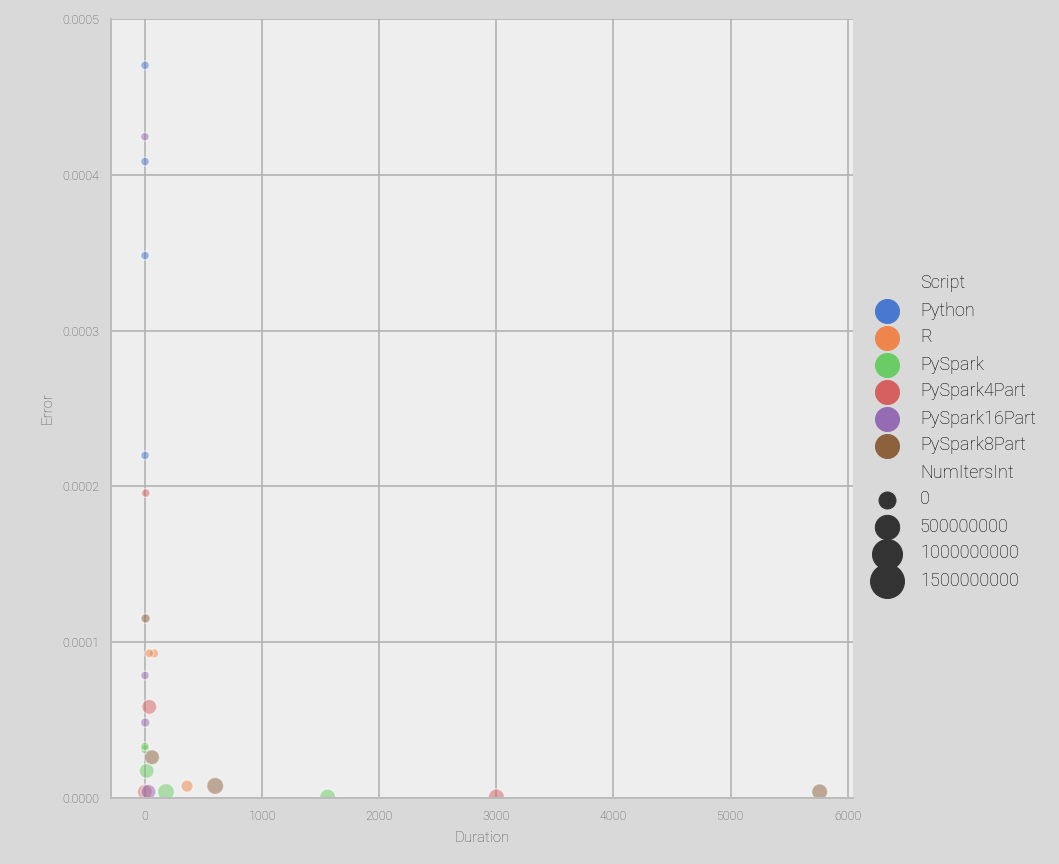

(0, 0.0005)

In [153]:
# Plot with Pandas and MatPlotLib
#pdf1.plot(kind='scatter',x='Duration',y='Error',title='Error Size Compared To Job Duration')

sns.relplot(x="Duration", y="Error", hue="Script", alpha=.5, palette="muted",
            size="NumItersInt", height=6, data=pdf1)
plt.ylim(0, 0.0005)

### Filter Results to Error under 0.00025

In [134]:
# Filter by Error value
pdf2=df_PiEsts.filter('Error < 0.00025').toPandas()
pdf2.style

,Script,PiEst,NumIters,ProcTime,Status,Duration,Error,NumItersInt
0,Python,3.14137,7500000,30.7701,Success,1,0.000219854,7500000
1,R,3.1416,500000000,416.749,Success,360,7.34641e-06,500000000
2,R,3.1415,100000000,85.422,Success,77,9.26536e-05,100000000
3,R,3.1415,50000000,41.148,Success,37,9.26536e-05,50000000
4,PySpark,3.14159,100000000000,10.964,Success,1560,3.3237e-07,1215752192
5,PySpark,3.14159,10000000000,1.19598,Success,180,3.64219e-06,1410065408
6,PySpark,3.14158,1000000000,0.1358,Success,15,1.71236e-05,1000000000
7,PySpark,3.14162,100000000,0.0424327,Success,2,3.11064e-05,100000000
8,PySpark,3.14163,10000000,0.0353514,Success,0.004,3.29464e-05,10000000
9,PySpark4Part,3.14159,100000000000,17.2023,Success,3000,3.9791e-07,1215752192


<IPython.core.display.Javascript object>


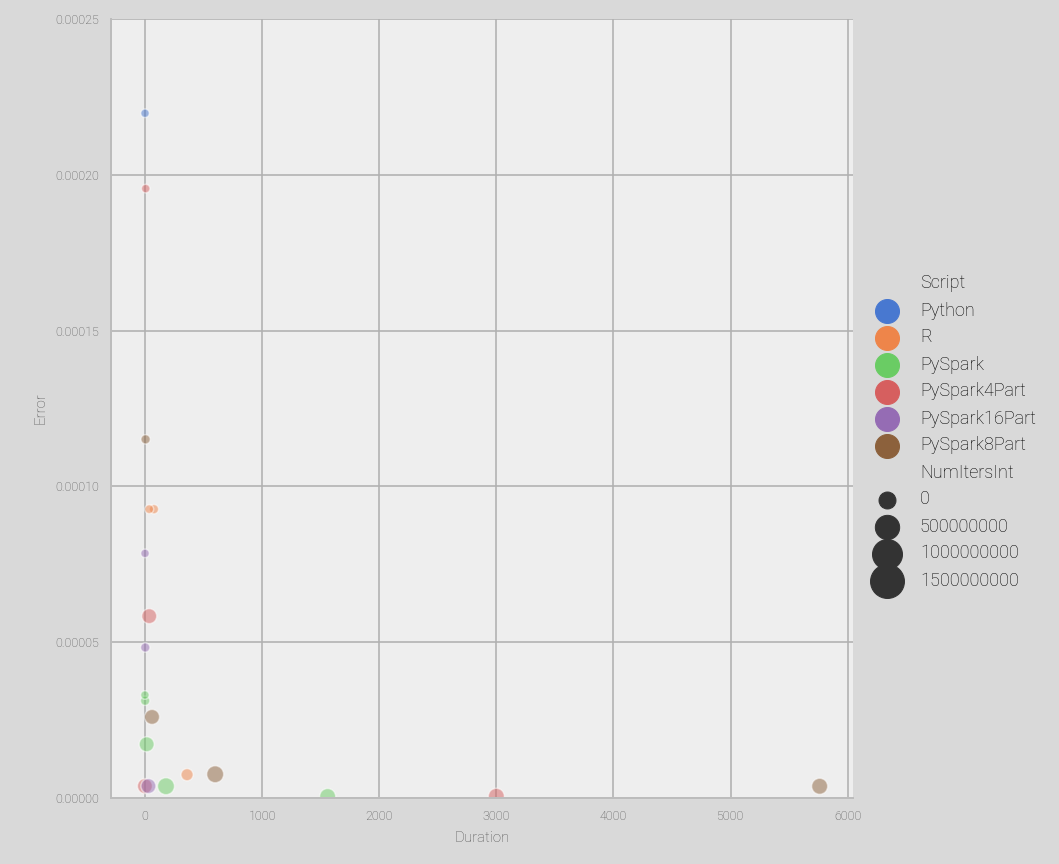

(0, 0.00025)

In [146]:
# Plot with Pandas and MatPlotLib
#pdf2.plot(kind='scatter',x='Duration',y='Error',title='Error Size Compared To Job Duration',ylim=(0,0.00025))

sns.relplot(x="Duration", y="Error", hue="Script", alpha=.5, palette="muted",
            size="NumItersInt", height=6, data=pdf2)
plt.ylim(0, 0.00025)


In [127]:
# Filter by Error value
pdf3=df_PiEsts.filter('Error < 0.000005').toPandas()
pdf3.style

,Script,PiEst,NumIters,ProcTime,Status,Duration,Error,NumItersInt
0,PySpark,3.14159,100000000000,10.964,Success,1560,3.3237e-07,1215752192
1,PySpark,3.14159,10000000000,1.19598,Success,180,3.64219e-06,1410065408
2,PySpark4Part,3.14159,100000000000,17.2023,Success,3000,3.9791e-07,1215752192
3,PySpark4Part,3.14159,1000000000,0.06,Success,0.003,3.68559e-06,1000000000
4,PySpark16Part,3.14159,1000000000,0.0578282,success,30,3.68559e-06,1000000000
5,PySpark8Part,3.1416,100000000000,31.8817,success,5760,3.62393e-06,1215752192


### Filter Results to Error under 0.000005

<IPython.core.display.Javascript object>


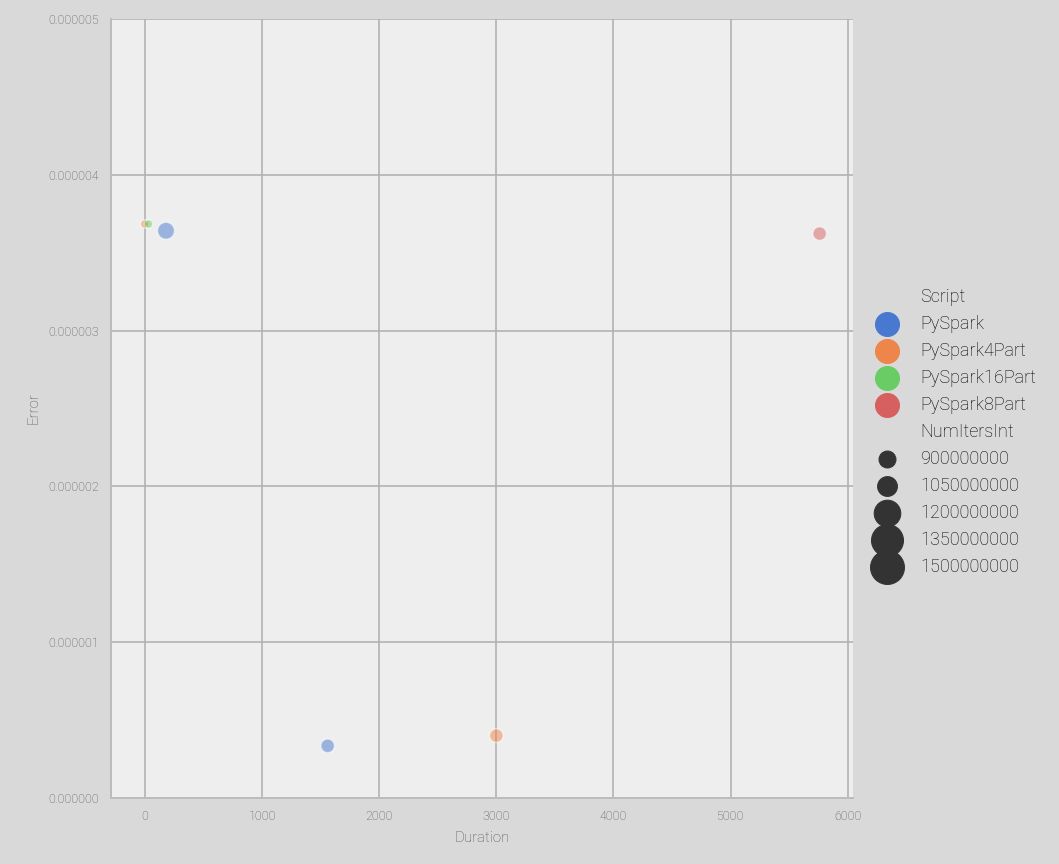

(0, 5e-06)

In [148]:
# Plot with Pandas and MatPlotLib
#pdf3.plot(kind='scatter',x='Duration',y='Error',title='Error Size Compared To Job Duration',ylim=(0,0.000005))

sns.relplot(x="Duration", y="Error", hue="Script", alpha=.5, palette="muted",
            size="NumItersInt", height=6, data=pdf3)
plt.ylim(0, 0.000005)

<IPython.core.display.Javascript object>


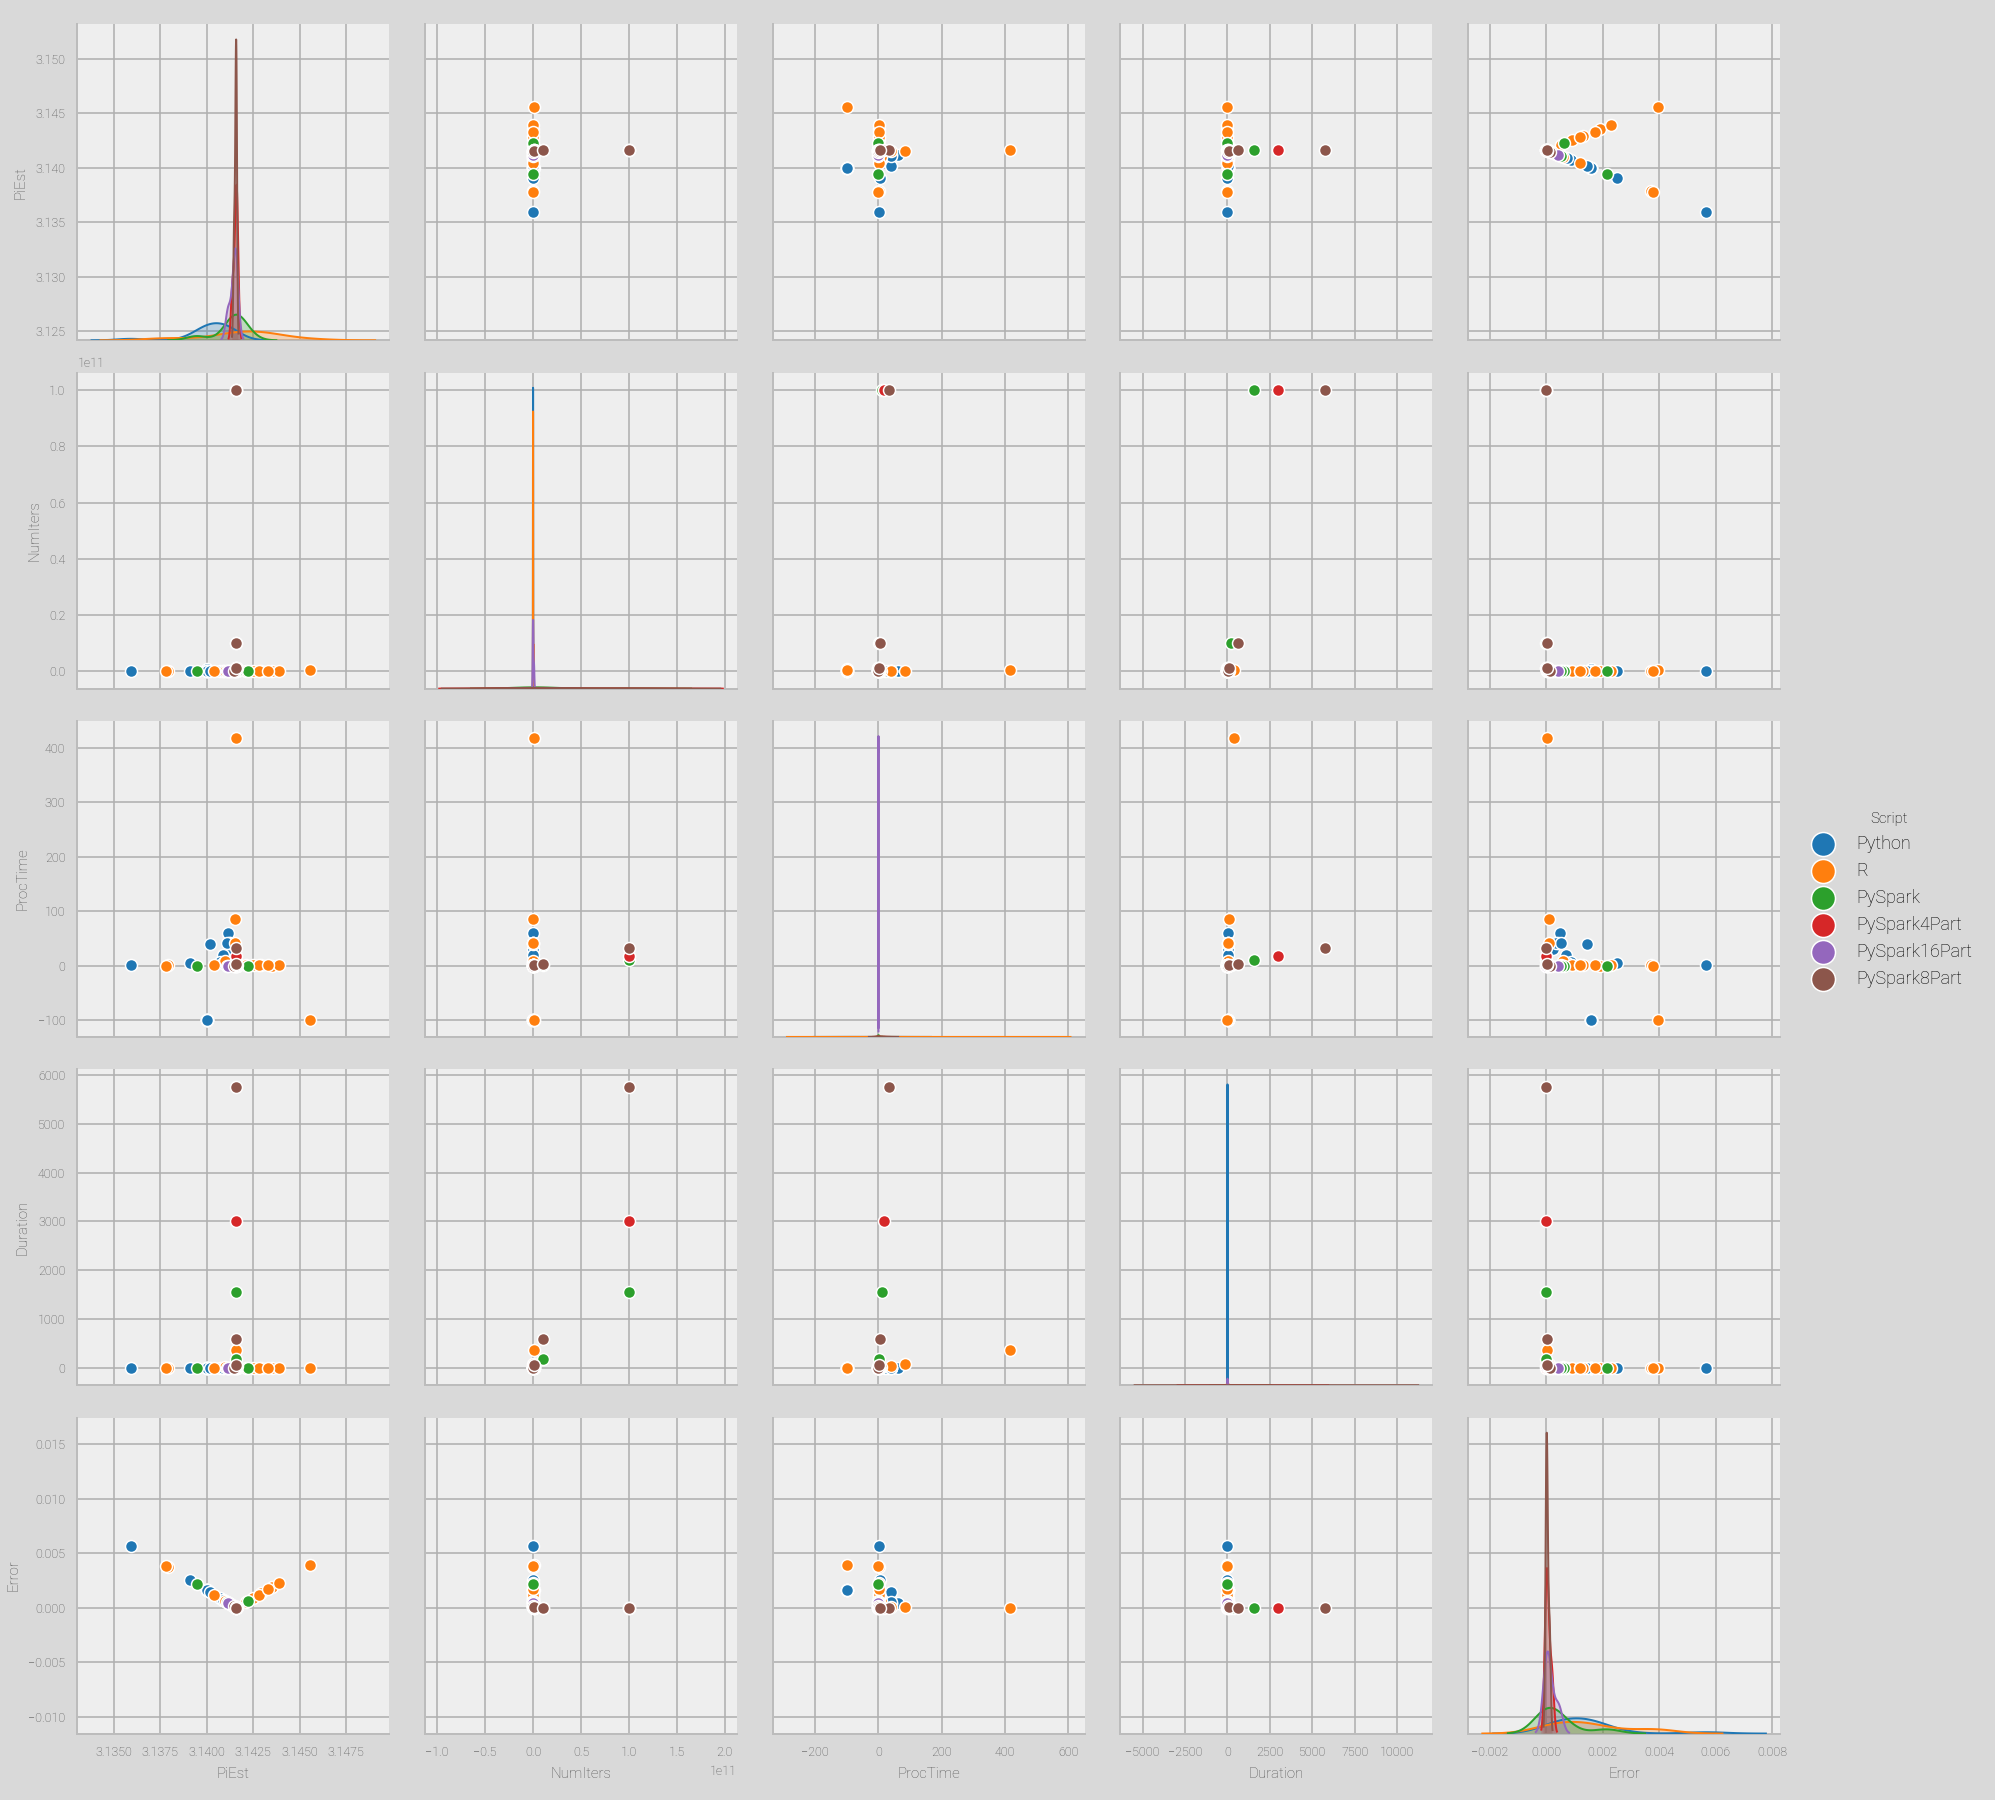

In [92]:
import seaborn as sns

sns.pairplot(data=df_PiEsts.toPandas(), hue='Script')